In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
input_path = 'H:\RediMinds\VCQI'
df_filter2_codes = pd.read_csv(input_path+"\VCQI_clean.csv")

In [3]:
# sepearte traget variable from predictors for furthur processing
X = df_filter2_codes.drop(columns=['INTRA-OP COMPLICATION'])
Y = df_filter2_codes['INTRA-OP COMPLICATION']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 33 columns):
PROC NAME                          2852 non-null int64
GENDER                             2852 non-null int64
AGE AT SURGERY                     2852 non-null float64
MARITAL STATUS                     2852 non-null int64
RACE                               2852 non-null int64
WEIGHT                             2852 non-null float64
HEIGHT                             2852 non-null float64
BMI                                2852 non-null float64
CLINICAL SIZE (mm)                 2852 non-null float64
SYMPTOMS                           2852 non-null int64
SOLITARY KIDNEY                    2852 non-null int64
BILATERALITY OF TUMOR              2852 non-null int64
SIDE OF TUMOR                      2852 non-null int64
SIDE OF SURGERY                    2852 non-null int64
FACE                               2852 non-null int64
TUMOR lOCATION                     2852 non-null int64
PRE

In [12]:
# Split data in test and train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify = Y)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_sample(x_train, y_train)

In [28]:
y_train.sum(),len(y_train) 

(1867, 3734)

In [46]:
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=2)
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

# Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = {'DTC__max_features':['sqrt','log2',None],
                  'DTC__min_samples_leaf': [1,5,10,15,20,25,30,35,40,45,50], 
                  'DTC__class_weight' :[None,'balanced'], 
                  'DTC__random_state': [1234]}


clf = Pipeline(steps=[('SMOTE',sm),
                      ('DTC', DecisionTreeClassifier())])
classifier_DTC = GridSearchCV(clf, parameter_dist, n_jobs = -1, scoring = 'roc_auc', cv = 5 )
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


In [49]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [50]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

{'DTC__class_weight': None, 'DTC__max_features': None, 'DTC__min_samples_leaf': 50, 'DTC__random_state': 1234}

 Model Best CV score: 
0.8203028352829342

 Model Balanced Accuracy: 
0.7399160140733174

 Confusion Matrix : 
[[763  38]
 [ 26  29]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       801
           1       0.43      0.53      0.48        55

    accuracy                           0.93       856
   macro avg       0.70      0.74      0.72       856
weighted avg       0.93      0.93      0.93       856


 AUC-ROC: 
0.8640108954715696


In [57]:
def bootstrapped_AUC(result):
    from sklearn.utils import resample
    from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [58]:
roc_auc_DTC, pr_auc_DTC = bootstrapped_AUC(results_DTC)

In [59]:
dict = {'roc_auc_DTC': roc_auc_DTC,
        'pr_auc_DTC': pr_auc_DTC,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_DTC,pr_auc_DTC
count,10000.000000,10000.000000
mean,0.863642,0.600670
std,0.029729,0.062765
min,0.725371,0.298238
2.5%,0.800683,0.471465
50%,0.865189,0.603283
97.5%,0.917439,0.717357
max,0.957644,0.810684


# Random Forest Classifier

In [53]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state= 42)
parameter_dist = {'RFC__n_estimators': [5,10,20,100,200,300], 
                  'RFC__max_features':['sqrt','log2',None],
                  'RFC__min_samples_leaf': [5,10,20,25,30,35,40,45,50], 
                  'RFC__class_weight' :[None] 
} 

clf = Pipeline(steps=[('SMOTE',sm),
                      ('RFC', RandomForestClassifier(random_state= 42))])
classifier_RFR = GridSearchCV(clf, parameter_dist, n_jobs = -1,cv=5, scoring = 'roc_auc', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)
y_RFR = results_classifier_RFR.predict(x_test)


In [54]:
classifier = results_classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [55]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_RFR)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

{'RFC__class_weight': None, 'RFC__max_features': None, 'RFC__min_samples_leaf': 40, 'RFC__n_estimators': 20}

 Model Best CV score: 
0.8552046706421977

 Model Balanced Accuracy: 
0.8079219157870843

 Confusion Matrix : 
[[770  31]
 [ 19  36]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       801
           1       0.54      0.65      0.59        55

    accuracy                           0.94       856
   macro avg       0.76      0.81      0.78       856
weighted avg       0.95      0.94      0.94       856


 AUC-ROC: 
0.8667801611621836


In [60]:
roc_auc_RFR, pr_auc_RFR = bootstrapped_AUC(results_RFR)

In [61]:
dict = {'roc_auc_RFR': roc_auc_RFR,
        'pr_auc_RFR': pr_auc_RFR,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_RFR,pr_auc_RFR
count,10000.000000,10000.000000
mean,0.866278,0.643947
std,0.032748,0.063903
min,0.721546,0.287542
2.5%,0.795800,0.513746
50%,0.868401,0.646615
97.5%,0.925336,0.763058
max,0.961229,0.850648


# Prepare data for Logistic Regression

In [4]:
# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


logit_data = X.copy()
for col in cat_col:
    if not col == 'INTRA-OP COMPLICATION':
        logit_data = logit_data.merge(pd.get_dummies(X[col], prefix=col), how = 'left', left_index = True, right_index =True) # create dummy variables
        logit_data = logit_data.drop(labels = col, axis = 'columns') # drop original variables

In [5]:
logit_data.head()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
0,50.0,57.00,168.0,20.20,7.0,13.2,50.0,7800.0,0.63,100.030000,...,0,0,0,0,1,0,0,1,0,0
1,69.0,68.60,161.3,26.37,74.0,14.7,44.2,6400.0,0.80,71.119672,...,0,0,0,0,0,1,0,0,0,1
2,83.0,83.65,164.0,31.10,80.0,12.5,38.9,5590.0,0.97,54.844682,...,0,0,1,0,0,0,0,1,0,0
3,66.0,107.00,180.0,32.78,73.0,17.0,50.8,8000.0,0.93,81.290783,...,0,0,0,0,0,1,0,1,0,0
4,61.0,82.90,171.0,28.35,8.0,12.1,37.1,7710.0,1.10,68.053260,...,0,0,0,0,1,0,0,1,0,0


In [6]:
# Split data in test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(logit_data, Y, test_size=0.30, random_state=42, stratify = Y)

In [7]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test))

Number of records in trainset 1996
Number records in testset 856


In [9]:
x_train.describe()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
count,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.00000,1996.000000,1996.000000,1996.000000,1996.000000,...,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,58.372044,82.954813,169.671799,29.108720,32.668567,13.75272,40.847144,7628.099950,0.974832,80.176668,...,0.094188,0.202906,0.323146,0.225451,0.146293,0.305110,0.029559,0.569639,0.280561,0.120240
std,12.408945,16.083585,9.399208,5.566018,16.184561,1.62571,4.054142,2346.171249,0.317895,21.323836,...,0.292164,0.402264,0.467795,0.417984,0.353488,0.460569,0.169410,0.495251,0.449386,0.325324
min,18.000000,7.711150,105.000000,15.100000,0.000000,1.30000,1.800000,1060.000000,0.330000,10.636826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,75.000000,167.600000,25.460000,22.000000,13.20000,40.300000,6900.000000,0.800000,68.037500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.000000,81.480000,169.350000,28.690000,30.000000,13.77000,41.050000,7640.820000,0.920000,80.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,87.000000,174.000000,31.512500,40.000000,14.50000,42.000000,7640.820000,1.100000,90.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,89.000000,171.000000,203.000000,50.000000,125.000000,39.60000,88.000000,56000.000000,4.120000,207.510000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
x_test.describe()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
count,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,...,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000
mean,58.321939,81.595135,169.538084,28.714157,32.772336,13.709509,40.845386,7509.014579,0.990338,80.673075,...,0.089953,0.188084,0.327103,0.197430,0.147196,0.328271,0.036215,0.547897,0.297897,0.117991
std,12.479285,14.408589,9.037408,5.154095,15.929753,1.416609,3.862590,1715.596723,0.535341,22.417460,...,0.286282,0.391008,0.469429,0.398292,0.354509,0.469859,0.186934,0.497992,0.457601,0.322786
min,17.000000,45.000000,125.000000,17.150000,1.200000,4.780000,15.000000,2800.000000,0.360000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,75.000000,167.000000,25.372500,22.000000,13.200000,40.275000,6700.000000,0.780000,68.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.000000,81.480000,169.350000,28.690000,31.000000,13.770000,41.050000,7640.820000,0.910000,80.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,85.525000,172.700000,31.000000,41.250000,14.500000,41.900000,7640.820000,1.100000,89.925000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,87.000000,172.370000,211.000000,48.400000,100.000000,19.700000,73.500000,18100.000000,9.740000,210.865863,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


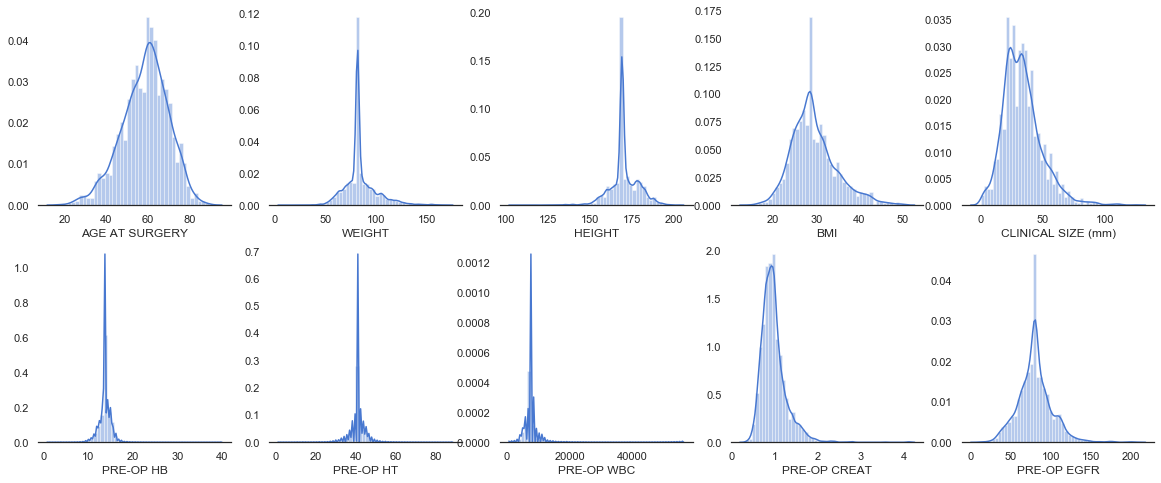

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.distplot(x_train['AGE AT SURGERY'], ax=axes[0, 0])
sns.distplot(x_train['WEIGHT'], ax=axes[0, 1])
sns.distplot(x_train['HEIGHT'],ax=axes[0,2])
sns.distplot(x_train['BMI'], ax=axes[0,3])
sns.distplot(x_train['CLINICAL SIZE (mm)'], ax=axes[0, 4])
sns.distplot(x_train['PRE-OP HB'], ax=axes[1, 0])
sns.distplot(x_train['PRE-OP HT'], ax=axes[1, 1])
sns.distplot(x_train['PRE-OP WBC'], ax=axes[1, 2])
sns.distplot(x_train['PRE-OP CREAT'],ax=axes[1,3])
sns.distplot(x_train['PRE-OP EGFR'], ax=axes[1,4])


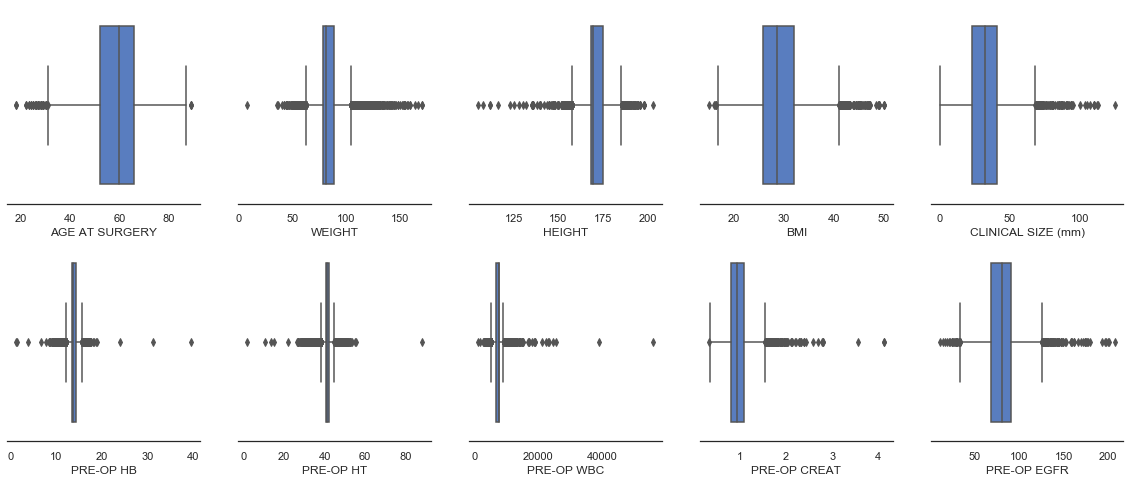

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.boxplot(x_train['AGE AT SURGERY'], ax=axes[0, 0])
sns.boxplot(x_train['WEIGHT'], ax=axes[0, 1])
sns.boxplot(x_train['HEIGHT'],ax=axes[0,2])
sns.boxplot(x_train['BMI'], ax=axes[0,3])
sns.boxplot(x_train['CLINICAL SIZE (mm)'], ax=axes[0, 4])
sns.boxplot(x_train['PRE-OP HB'], ax=axes[1, 0])
sns.boxplot(x_train['PRE-OP HT'], ax=axes[1, 1])
sns.boxplot(x_train['PRE-OP WBC'], ax=axes[1, 2])
sns.boxplot(x_train['PRE-OP CREAT'],ax=axes[1,3])
sns.boxplot(x_train['PRE-OP EGFR'], ax=axes[1,4])


In [36]:
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [37]:
sm = SMOTE(random_state=2)
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__class_weight': [None] ,
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000]}


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('SMOTE',sm),
                      ('classifier', LogisticRegression())])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring='roc_auc', cv = 5)

In [43]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

In [44]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [45]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

{'classifier__class_weight': None, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

 Model Best CV score: 
0.8496087063309349

 Model Balanced Accuracy: 
0.6714788332765861

 Confusion Matrix : 
[[799   2]
 [ 36  19]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       801
           1       0.90      0.35      0.50        55

    accuracy                           0.96       856
   macro avg       0.93      0.67      0.74       856
weighted avg       0.95      0.96      0.95       856


 AUC-ROC: 
0.908046759732153


In [60]:
roc_auc_logit, pr_auc_logit = bootstrapped_AUC(results_logit)

In [67]:
dict = {'roc_auc_logit': roc_auc_logit,
        'pr_auc_logit': pr_auc_logit,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_logit,pr_auc_logit
count,10000.000000,10000.000000
mean,0.906022,0.570869
std,0.021562,0.070690
min,0.790102,0.242312
2.5%,0.860570,0.426746
50%,0.907081,0.573296
97.5%,0.945230,0.701480
max,0.968505,0.828110


# Compare Classifiers

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


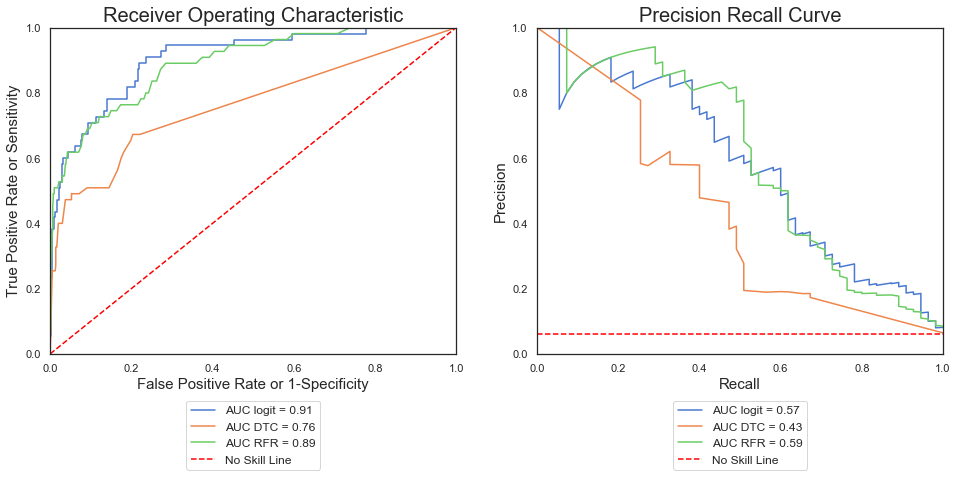

In [68]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_logit
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [252]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
rfe = RFE(logreg, 30)
rfe = rfe.fit(x_test, y_test)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False  True  True False False False  True False False  True
 False False False  True False False  True False False False  True  True
 False  True False False False False  True False  True False False False
  True False False False  True False False False  True  True  True False
  True False False  True False False  True False False False False False
 False False False False  True False  True False  True False  True False
  True False False False  True False  True False  True False  True False
 False False  True  True False False]
[ 9 55 31 48 63 33 61  6 40 41 13 71 30 32 64  1  1 53 70 37  1  8 29  1
 60 56 12  1 23 54  1  4 28  5  1  1 46  1 42 72 22 67  1  3  1  2 10 50
  1 34 16 45  1 17 73 51  1  1  1 52  1 59 20  1 21 65  1 62 39 35 66 57
 69 58 44 43  1 36  1 15  1 19  1  7  1 25 38 24  1 27  1 14  1 26  1 47
 68 49  1  1 11 18]


In [253]:
x_test.columns[rfe.support_]

Index(['MARITAL STATUS_0', 'MARITAL STATUS_1', 'RACE_0', 'RACE_3',
       'SYMPTOMS_2', 'SOLITARY KIDNEY_1', 'BILATERALITY OF TUMOR_2',
       'SIDE OF TUMOR_0', 'SIDE OF TUMOR_2', 'SIDE OF SURGERY_3', 'FACE_1',
       'TUMOR lOCATION_2', 'POLAR LOCATION_2', 'RENAL SINUS_3',
       'RENAL SINUS_4', 'EXOPHYTIC RATE_0', 'EXOPHYTIC RATE_2',
       'CLINICAL SIZE GROUP_1', 'CT_0', 'CN_3', 'CM_1', 'CM_3',
       'RADIUS (maximal diameter in cm)_1',
       'RADIUS (maximal diameter in cm)_3',
       'EXOPHYTIC/ENDOPHYTIC PROPERTIES_3', 'ANTERIOR OR POSTERIOR_1',
       'ANTERIOR OR POSTERIOR_3', 'ASA SCORE_1', 'PARTIAL NEPHRO INDICATION_0',
       'PARTIAL NEPHRO INDICATION_1'],
      dtype='object')

In [254]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_train[x_test.columns[rfe.support_]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.157566
         Iterations 9
                                 Results: Logit
Model:                   Logit                    Pseudo R-squared:    0.347     
Dependent Variable:      INTRA-OP COMPLICATION    AIC:                 778.8176  
Date:                    2019-08-05 16:07         BIC:                 950.7887  
No. Observations:        2281                     Log-Likelihood:      -359.41   
Df Model:                29                       LL-Null:             -550.56   
Df Residuals:            2251                     LLR p-value:         2.8266e-63
Converged:               1.0000                   Scale:               1.0000    
No. Iterations:          9.0000                                                  
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------